In [1]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA


In [ ]:
df = pd.read_csv("/content/HousingPrices-Amsterdam-August-2021.csv")

###Data Cleaning and Visualisation

In [ ]:
shape = df.shape
print(f"The data has {shape[0]} rows and {shape[1]} columns.")

The data has 924 rows and 8 columns.


In [ ]:
df.head()

,Unnamed: 0,Address,Zip,Price,Area,Room,Lon,Lat
0,1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157
1,2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586
2,3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782
3,4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712
4,5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538


In [ ]:
df.dropna(axis=0, subset=["Price"], inplace=True)
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [ ]:
upper_quartile = np.percentile(df.Price, [25, 50, 75])[-1]
lower_quartile = np.percentile(df.Price, [25, 50, 75])[0]


iqr = np.percentile(df.Price, [25, 50, 75])[-1] - np.percentile(df.Price, [25, 50, 75])[0]
upper_bound = upper_quartile + 1.5 * iqr
outliers = df[df.Price > upper_bound]

df.drop(outliers.index, inplace= True)
df.index = np.arange(0, 849)

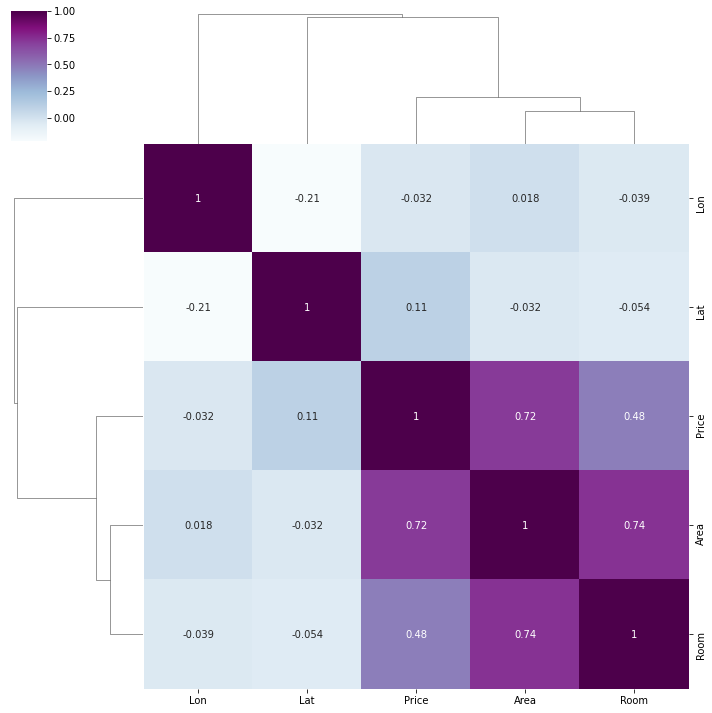

In [ ]:
sns.clustermap(df.corr(), annot=True, cmap="BuPu")

In [ ]:
df.groupby(["Room"])["Price"].describe()

,count,mean,std,min,25%,50%,75%,max
Room,,,,,,,,
1,17.0,394529.411765,241565.756484,175000.0,240000.0,295000.0,400000.0,950000.0
2,190.0,377865.789474,147572.058045,179000.0,295000.0,350000.0,415000.0,1175000.0
3,324.0,490609.293210,188810.997402,225000.0,350000.0,450000.0,577500.0,1200000.0
4,186.0,525289.591398,213765.784510,260000.0,349250.0,475000.0,650000.0,1200000.0
5,82.0,698370.865854,257919.559326,265000.0,488500.0,698500.0,893000.0,1200000.0
6,33.0,700060.606061,222523.024005,350000.0,550000.0,699000.0,800000.0,1150000.0
7,12.0,922916.666667,165988.202392,600000.0,843750.0,950000.0,1012500.0,1175000.0
8,4.0,937250.000000,228874.601766,700000.0,774250.0,924500.0,1087500.0,1200000.0
9,1.0,900000.000000,NaN,900000.0,900000.0,900000.0,900000.0,900000.0


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


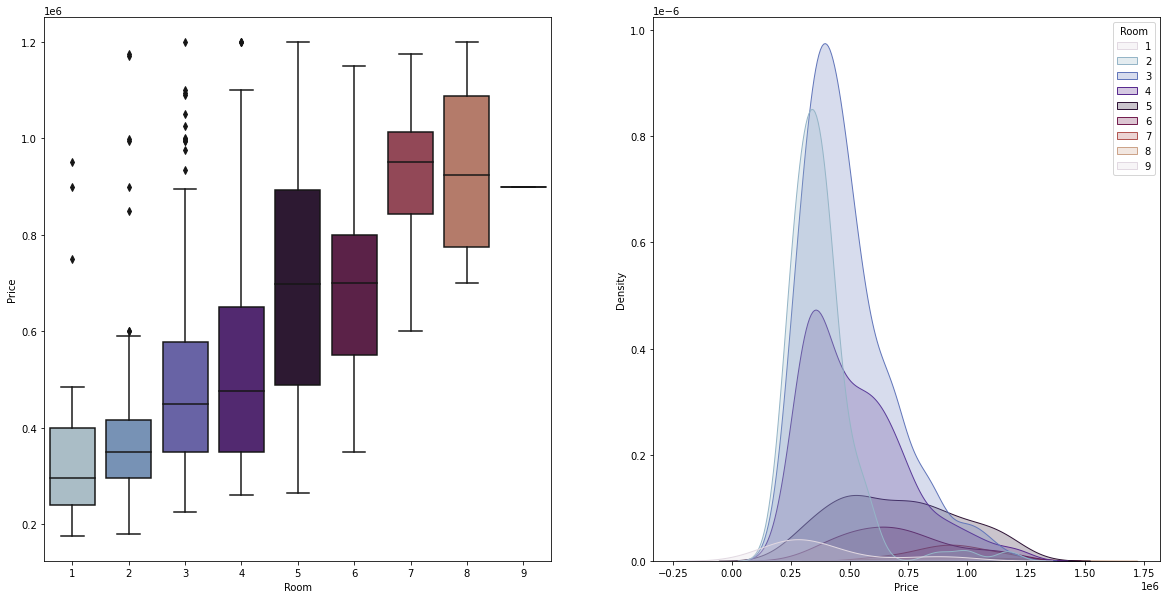

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
sns.boxplot(data=df, x='Room', y='Price', palette="twilight", ax=axes[0])
sns.kdeplot(data=df, x='Price', hue= "Room", palette="twilight", ax=axes[1], fill=True, alpha=0.25)

plt.show()

In [ ]:
def price_brackets(price, interval=150000):
  upper_bound = interval * (np.floor(price/interval) + 1)
  lower_bound = interval * np.floor(price/interval)
  return f"{lower_bound} to {upper_bound}"


<Figure size 1080x1080 with 0 Axes>

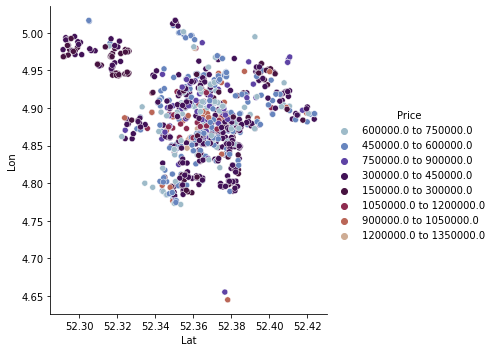

In [ ]:
plt.figure(figsize=(15, 15))
sns.relplot(x="Lat", y="Lon", hue=df.Price.apply(price_brackets), data=df, palette="twilight")

Text(0.5, 1.0, 'The relationship between the price of a house and its total area')

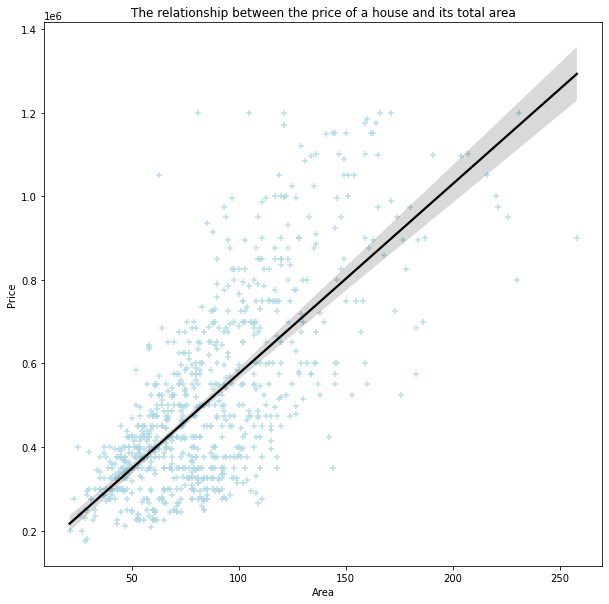

In [ ]:
plt.figure(figsize=(10,10))
sns.regplot(x=df["Area"], y=df["Price"], line_kws={"color": "black"}, scatter_kws={"color": "lightblue"}, marker= "+")
plt.title("The relationship between the price of a house and its total area")

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

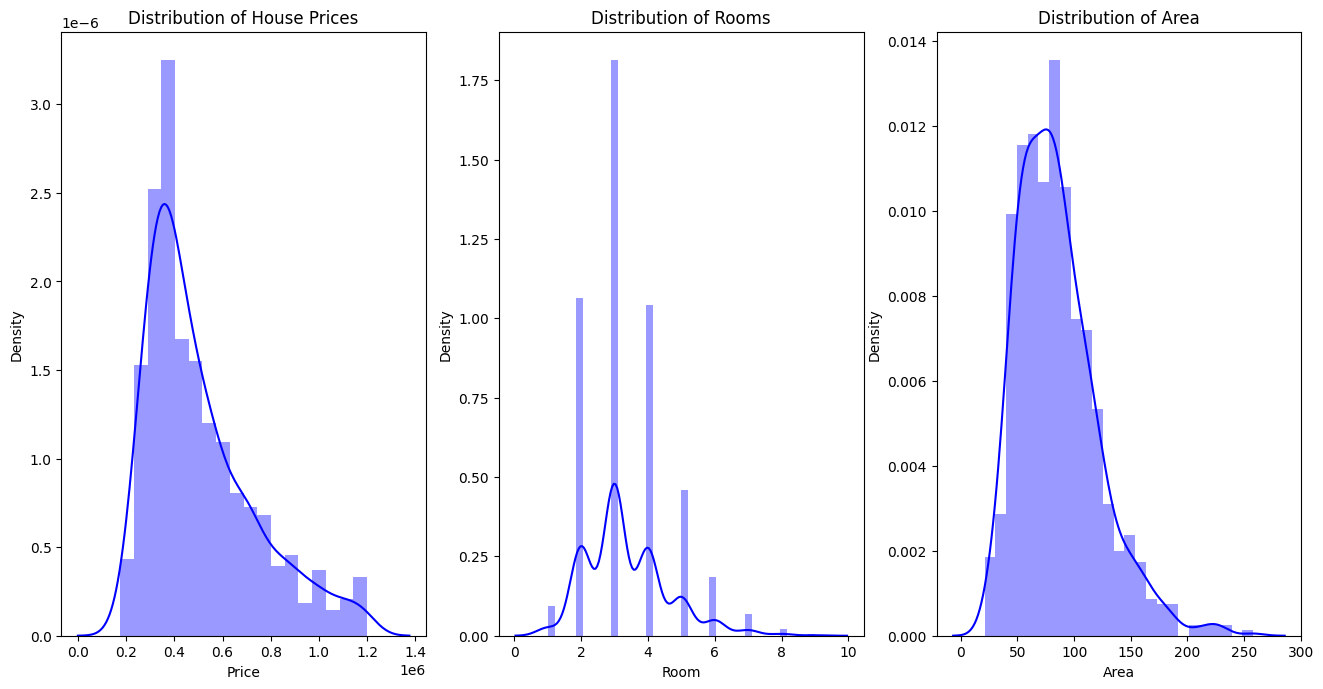

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8), dpi=100)

sns.distplot(df['Price'], ax=ax1, color="blue")
ax1.set_title('Distribution of House Prices')
sns.distplot(df['Room'], ax=ax2, color="blue")
ax2.set_title('Distribution of Rooms')
sns.distplot(df['Area'], ax=ax3, color="blue")
ax3.set_title('Distribution of Area')

plt.tight_layout
plt.show()

###Feature Engineering

In [ ]:
def search_district(zip_code):
  ''' returns the district in Amsterdam based off the zipcode '''
  zip_number = int(zip_code.split()[0])
  if zip_number == 1019 or zip_number in range(1086, 1100):
    return "Oost"
  elif zip_number in range(1100, 1110):
    return "Zuidoost"
  elif zip_number in range(1011, 1019):
    return "Centrum"
  elif zip_number in range(1020, 1040):
    return "Noord"
  elif zip_number in range(1040, 1050):
    return "Westpoort"
  elif zip_number in range(1050, 1060):
    return "West"
  elif zip_number in range(1070, 1084):
    return "Zuid"
  else:
    return "Nieuw-West"

def street_finder(address):
  ''' returns the street the property at the specified address is located at'''
  _ = address.split(",")[0]
  words = _.split()
  res = []
  for i in words:
    if i.isnumeric():
      break
    res.append(i)
  return " ".join(res)


In [ ]:
features = ["Lat", "Lon", "Room", "Area"]
data = df.loc[:, features]
data = (data - data.mean(axis=0))/data.std(axis=0)

In [ ]:
pca = PCA()
data_pca = pca.fit_transform(data)

component_names = [f"PC{i+1}" for i in range(data_pca.shape[1])]
data_pca = pd.DataFrame(data_pca, columns=component_names)

loadings = pd.DataFrame(
    pca.components_.T,
    columns=component_names,
    index=data.columns,
)
loadings

,PC1,PC2,PC3,PC4
Lat,-0.082125,0.699007,0.709308,-0.039090
Lon,0.003448,-0.712328,0.698770,-0.065550
Room,0.705239,0.056102,-0.012576,-0.706635
Area,0.704189,0.028822,0.091896,0.703450


In [ ]:
df["District"] = df["Zip"].apply(search_district)
df["Street"] = df["Address"].apply(street_finder)
df = pd.concat([df, data_pca], axis=1)

In [ ]:
df.drop(["Address", "Zip"], axis=1, inplace=True)

In [ ]:
df.groupby(["District"])["Price"].describe()

,count,mean,std,min,25%,50%,75%,max
District,,,,,,,,
Centrum,128.0,646933.593750,241614.104466,240000.0,443500.0,635000.0,806250.0,1200000.0
Nieuw-West,150.0,424966.666667,158448.313367,200000.0,315000.0,375000.0,499000.0,975000.0
Noord,98.0,471509.408163,214507.035224,175000.0,325000.0,380000.0,568750.0,1100011.0
Oost,117.0,539871.589744,199257.298271,230000.0,400000.0,500000.0,620000.0,1200000.0
West,173.0,502138.150289,208442.314091,199000.0,365000.0,430000.0,575000.0,1200000.0
Zuid,104.0,619117.788462,254563.263344,249000.0,392500.0,575000.0,825000.0,1175000.0
Zuidoost,79.0,304704.278481,80567.755219,179000.0,247500.0,280000.0,340000.0,600000.0


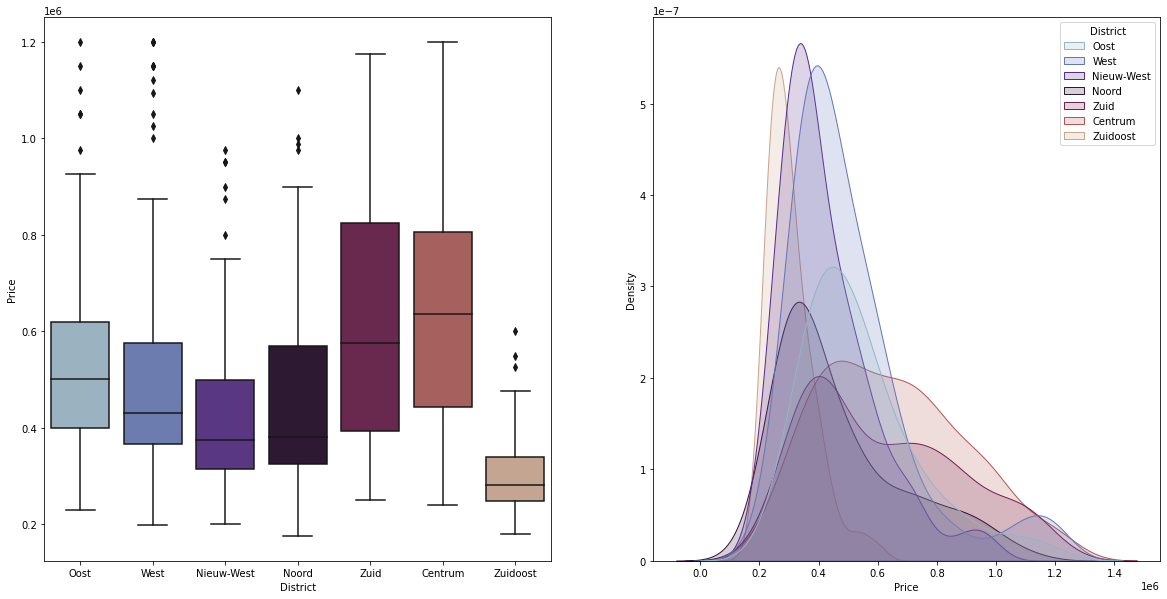

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
sns.boxplot(data=df, x='District', y='Price', palette="twilight", ax=axes[0])
sns.kdeplot(data=df, x='Price', hue= "District", palette="twilight", ax=axes[1], fill=True, alpha=0.2)

plt.show()

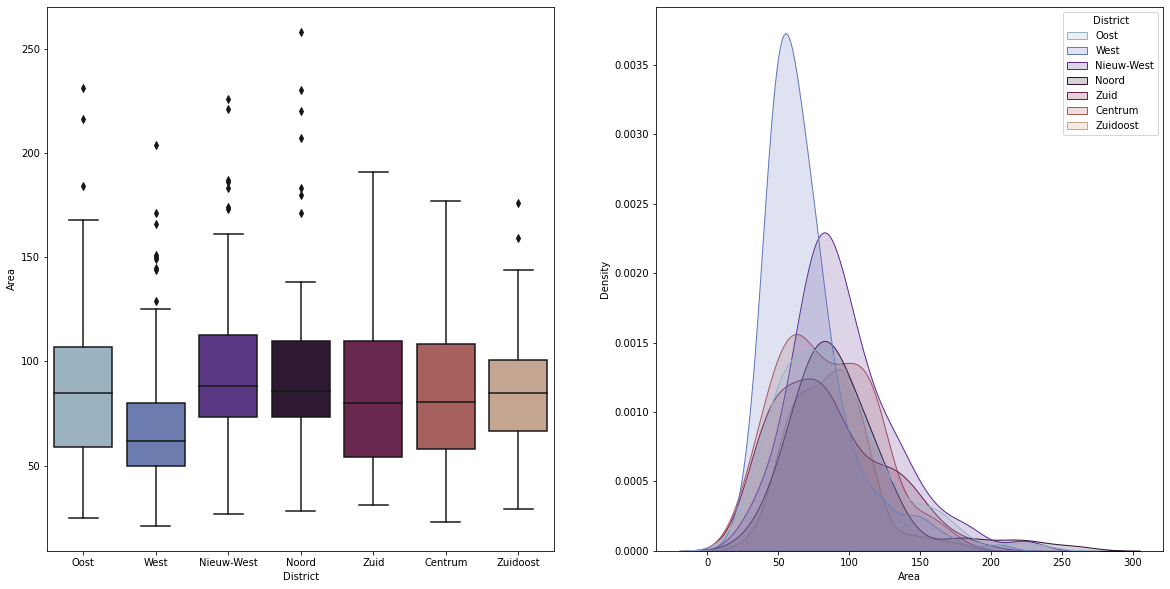

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
sns.boxplot(data=df, x='District', y='Area', palette="twilight", ax=axes[0])
sns.kdeplot(data=df, x='Area', hue= "District", palette="twilight", ax=axes[1], fill=True, alpha=0.2)

plt.show()

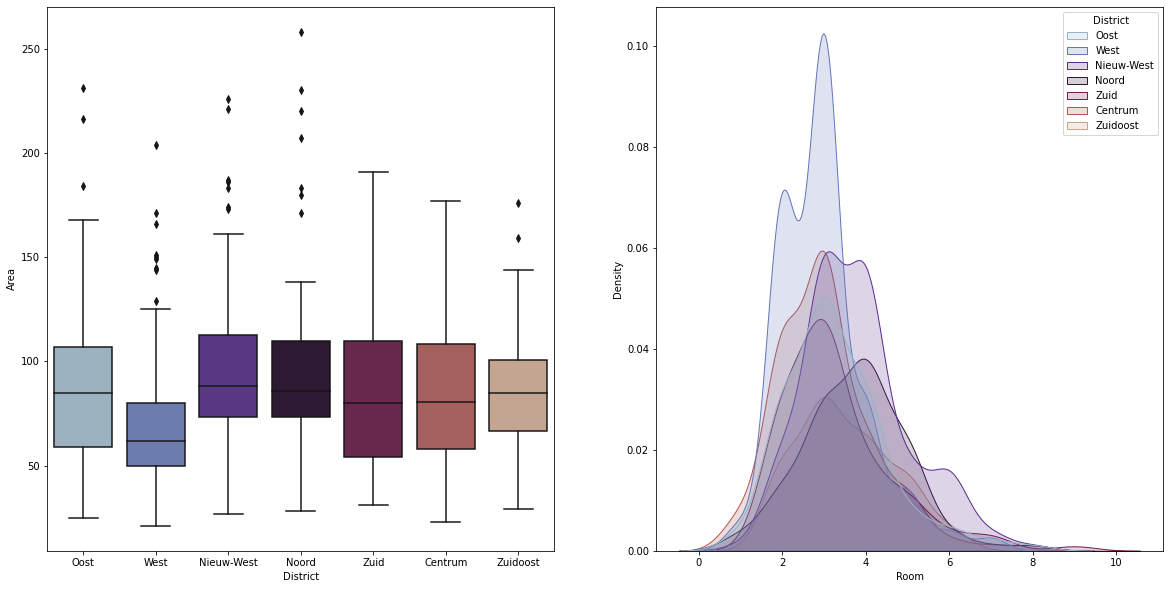

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
sns.boxplot(data=df, x='District', y='Area', palette="twilight", ax=axes[0])
sns.kdeplot(data=df, x='Room', hue= "District", palette="twilight", ax=axes[1], fill=True, alpha=0.2)

plt.show()

### Modelling

#### XGBoost Model

In [ ]:
cat_columns = ["District", "Street"]
num_columns = ["Area", "Room", "Lon", "Lat", "PC1", "PC2", "PC3", "PC4"]

preprocessor = make_column_transformer(
    (StandardScaler(), num_columns),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_columns),
)

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', XGBRegressor(n_estimators=200,
                                                     random_state=0,
                                                     objective ='reg:squarederror'))
                             ])

In [ ]:
X = df.copy()
y = X.pop("Price")

In [ ]:
scores = -1 * cross_val_score(xgb_pipeline, X, y,
                              cv=20,
                              scoring='neg_mean_absolute_error')
scores.mean()

62069.42901699196

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

my_model = XGBRegressor(n_estimators=100,
                        random_state=0,
                        objective ='reg:squarederror')
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)

print(f"Accuracy: {my_model.score(X_valid, y_valid).mean()}")

Accuracy: 0.847942329538698


#### K-Nearest Neighbours Model

In [ ]:
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', KNeighborsRegressor(n_neighbors=8))
                             ])
 
scores = -1 * cross_val_score(knn_pipeline, X, y,
                              cv=20,
                              scoring='neg_mean_absolute_error',
                              )

scores.mean()

67647.28524017165

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=8)
knn_model.fit(X_train, y_train)
print(f"Accuracy: {knn_model.score(X_valid, y_valid)}")

Accuracy: 0.8335527091243868


#### RandomForest Model

In [ ]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                         ('model', RandomForestRegressor(n_estimators=200,
                                                                         random_state=0))])

scores = -1 * cross_val_score(rf_pipeline, X, y,
                              cv=20,
                              scoring='neg_mean_absolute_error',
                              )

scores.mean()

59671.00718663317

In [ ]:
rf_model = RandomForestRegressor(n_estimators=200,
                                 random_state=0)
rf_model.fit(X_train, y_train)
print(f"Accuracy: {rf_model.score(X_valid, y_valid)}")

Accuracy: 0.8516451448907314
